## FID Lab

The following is all the code used in the FID lab:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [3]:
pip freeze

anyio @ file:///home/conda/feedstock_root/build_artifacts/bld/rattler-build_anyio_1742243108/work
APScheduler @ file:///home/conda/feedstock_root/build_artifacts/bld/rattler-build_apscheduler_1732499160/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1733311059102/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1725356572528/work
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1733584251875/work
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1733250440834/work
async-lru @ file:///home/conda/feedstock_root/build_artifacts/bld/rattler-build_async-lru_1742153708/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1741918516150/work
babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1738490167835/work
beautifulsoup4 @ file:///home/conda/feedstock_root/build_artifacts/beautifulsoup4_1744783198182/work
bleach @ file:///home/conda/feedstock

In [2]:
# Styling for academic plots
sns.set_theme(style="whitegrid", context="talk")

In [3]:
df = pd.read_csv("fid_data.csv")

Basic sanity check:

In [4]:
print(df.head())
print(df.dtypes)

   Observation_No        Species  Grass Neighbours    SD Treatment  FID  \
0             101  Laughing dove  False        NaN  11.0   control  2.0   
1             102  Laughing dove  False        NaN  11.0   control  0.5   
2             103    Common myna  False          G  12.1   control  4.0   
3             104    Common myna   True        NaN  11.9   control  6.6   
4             105  Laughing dove  False        NaN   9.7     angle  NaN   

   Immediate_flight  
0             False  
1             False  
2             False  
3             False  
4             False  
Observation_No        int64
Species              object
Grass                  bool
Neighbours           object
SD                  float64
Treatment            object
FID                 float64
Immediate_flight       bool
dtype: object


## Data viability

Mainly checking data encoding for analysis purposes, minor EDA:

In [5]:
df.isna().sum()

Observation_No       0
Species              0
Grass                0
Neighbours          32
SD                   0
Treatment            0
FID                  3
Immediate_flight     0
dtype: int64

<Axes: >

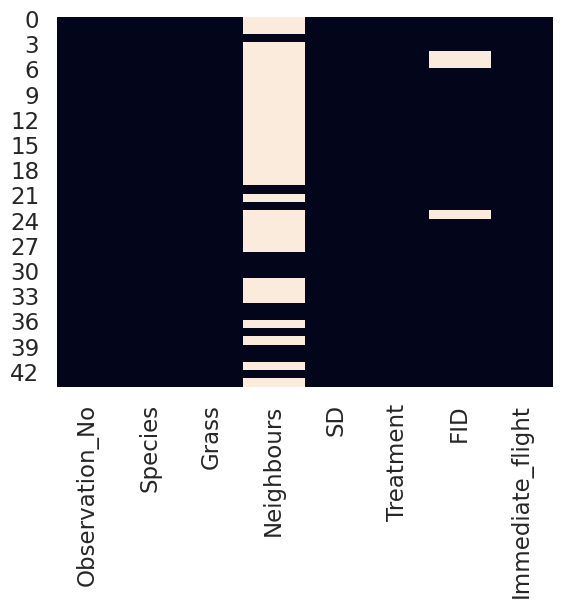

In [6]:
sns.heatmap(df.isna(), cbar=False)

In [32]:
df["FID"].describe()

count    41.000000
mean      3.595122
std       1.796378
min       0.500000
25%       2.000000
50%       3.500000
75%       4.400000
max       8.200000
Name: FID, dtype: float64

In [8]:
df["Species"].value_counts()

Species
Common myna      17
Monk parakeet    13
Upupa             8
Laughing dove     4
White wagtail     2
Name: count, dtype: int64

In [5]:
df_fid = df[df["FID"].notna()]

df_fid.groupby("Species")["FID"].describe()

,count,mean,std,min,25%,50%,75%,max
Species,,,,,,,,
Common myna,16.0,4.093750,1.584706,1.8,3.325,4.15,4.600,7.6
Laughing dove,2.0,1.250000,1.060660,0.5,0.875,1.25,1.625,2.0
Monk parakeet,13.0,2.469231,0.951652,1.0,1.800,2.50,3.000,4.5
Upupa,8.0,4.225000,1.842165,2.4,3.250,3.85,4.575,8.2
White wagtail,2.0,6.750000,1.060660,6.0,6.375,6.75,7.125,7.5


In [10]:
df_fid.groupby("Treatment")["FID"].describe()

,count,mean,std,min,25%,50%,75%,max
Treatment,,,,,,,,
angle,16.0,3.13125,1.464568,1.5,1.975,3.0,3.625,7.5
control,25.0,3.89200,1.949983,0.5,2.400,4.0,4.900,8.2


In [4]:
df["Immediate_flight"].value_counts(normalize=True)

Immediate_flight
False    0.863636
True     0.136364
Name: proportion, dtype: float64

In [5]:
pd.crosstab(df["Species"], df["Immediate_flight"], normalize="index")

Immediate_flight,False,True
Species,,
Common myna,0.941176,0.058824
Laughing dove,1.000000,0.000000
Monk parakeet,0.846154,0.153846
Upupa,0.875000,0.125000
White wagtail,0.000000,1.000000


In [6]:
df["FID"].isna().mean()

np.float64(0.06818181818181818)

In [7]:
pd.crosstab(df["Treatment"], df["FID"].isna(), normalize="index")

FID,False,True
Treatment,,
angle,0.842105,0.157895
control,1.000000,0.000000


In [8]:
df["SD"].describe()

count    44.000000
mean     11.156818
std       1.590144
min       7.400000
25%      10.000000
50%      11.050000
75%      12.000000
max      14.800000
Name: SD, dtype: float64

In [9]:
df.groupby("Treatment")["SD"].describe()

,count,mean,std,min,25%,50%,75%,max
Treatment,,,,,,,,
angle,19.0,11.010526,1.642794,8.6,9.85,10.7,11.8,14.5
control,25.0,11.268000,1.573669,7.4,10.00,11.8,12.0,14.8


Grass vs FID:

In [13]:
df_fid.groupby("Grass")["FID"].describe()

,count,mean,std,min,25%,50%,75%,max
Grass,,,,,,,,
False,7.0,2.857143,1.555482,0.5,2.0,2.40,4.100,4.9
True,34.0,3.747059,1.825449,1.0,2.5,3.55,4.475,8.2


Neighbours:

In [14]:
df_fid["Neighbours"].value_counts(dropna=False)

Neighbours
NaN    29
G      10
P       2
Name: count, dtype: int64

## EDA

First of, checking if the day of the observations influenced data collection (and thus creating a bias):

In [7]:
working_df = df.copy()

working_df["Day"] = np.select(
    [
        working_df["Observation_No"].between(101, 128),
        working_df["Observation_No"].between(229, 244)
    ],
    ["Day1", "Day2"],
    default="Other"
)

working_df["Day"].value_counts(dropna=False)

Day
Day1    28
Day2    16
Name: count, dtype: int64

In [19]:
pd.crosstab(working_df["Species"], working_df["Day"])

Day,Day1,Day2
Species,,
Common myna,15,2
Laughing dove,4,0
Monk parakeet,3,10
Upupa,4,4
White wagtail,2,0


In [20]:
pd.crosstab(working_df["Species"], working_df["Day"], normalize="columns")

Day,Day1,Day2
Species,,
Common myna,0.535714,0.125
Laughing dove,0.142857,0.000
Monk parakeet,0.107143,0.625
Upupa,0.142857,0.250
White wagtail,0.071429,0.000


In [21]:
working_df.groupby("Day")["Species"].nunique()

Day
Day1    5
Day2    3
Name: Species, dtype: int64

In [22]:
pd.crosstab(working_df["Day"], working_df["Immediate_flight"], normalize="index")

Immediate_flight,False,True
Day,,
Day1,0.892857,0.107143
Day2,0.812500,0.187500


In [23]:
pd.crosstab(working_df["Day"], working_df["FID"].isna(), normalize="index")

FID,False,True
Day,,
Day1,0.892857,0.107143
Day2,1.000000,0.000000


In [12]:
df_fid = working_df[working_df["FID"].notna()]

df_fid.groupby("Day")["FID"].describe()

,count,mean,std,min,25%,50%,75%,max
Day,,,,,,,,
Day1,25.0,3.74800,1.864832,0.5,2.000,4.00,4.5,7.6
Day2,16.0,3.35625,1.715019,1.0,2.375,3.15,4.0,8.2


In [28]:
df_fid.groupby(["Species", "Day"])["FID"].describe()

count      mean       std  min    25%   50%    75%  max
Species       Day                                                          
Common myna   Day1   14.0  4.135714  1.695971  1.8  2.875  4.30  4.800  7.6
              Day2    2.0  3.800000  0.282843  3.6  3.700  3.80  3.900  4.0
Laughing dove Day1    2.0  1.250000  1.060660  0.5  0.875  1.25  1.625  2.0
Monk parakeet Day1    3.0  2.266667  0.642910  1.8  1.900  2.00  2.500  3.0
              Day2   10.0  2.530000  1.047802  1.0  1.625  2.75  3.000  4.5
Upupa         Day1    4.0  3.250000  0.967815  2.4  2.475  3.10  3.875  4.4
              Day2    4.0  5.200000  2.108712  3.5  3.875  4.55  5.875  8.2
White wagtail Day1    2.0  6.750000  1.060660  6.0  6.375  6.75  7.125  7.5

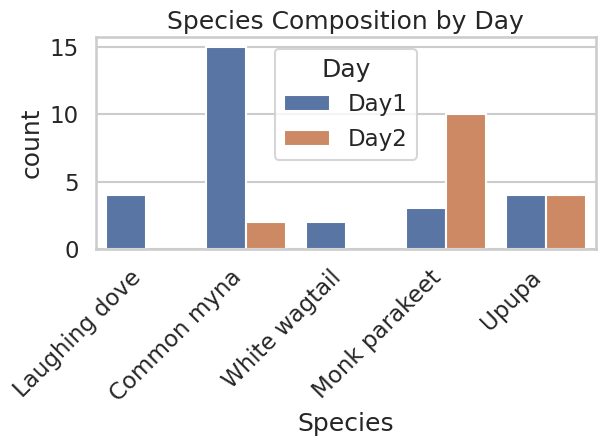

In [29]:
sns.countplot(data=working_df, x="Species", hue="Day")
plt.xticks(rotation=45, ha="right")
plt.title("Species Composition by Day")
plt.tight_layout()
plt.show()

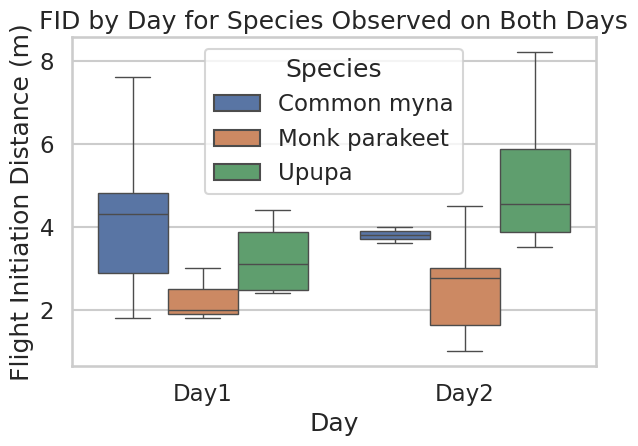

In [14]:
shared_species = (
    df_fid.groupby("Species")["Day"]
    .nunique()
    .loc[lambda x: x == 2]
    .index
)

df_shared = df_fid[df_fid["Species"].isin(shared_species)]

sns.boxplot(
    data=df_shared,
    x="Day",
    y="FID",
    hue="Species"
)
plt.title("FID by Day for Species Observed on Both Days")
plt.ylabel("Flight Initiation Distance (m)")
plt.tight_layout()
plt.show()

In [31]:
working_df.groupby("Day")["SD"].describe()

,count,mean,std,min,25%,50%,75%,max
Day,,,,,,,,
Day1,28.0,11.089286,1.698875,7.4,9.875,11.00,12.0,14.8
Day2,16.0,11.275000,1.424781,8.6,10.150,11.55,12.0,14.0


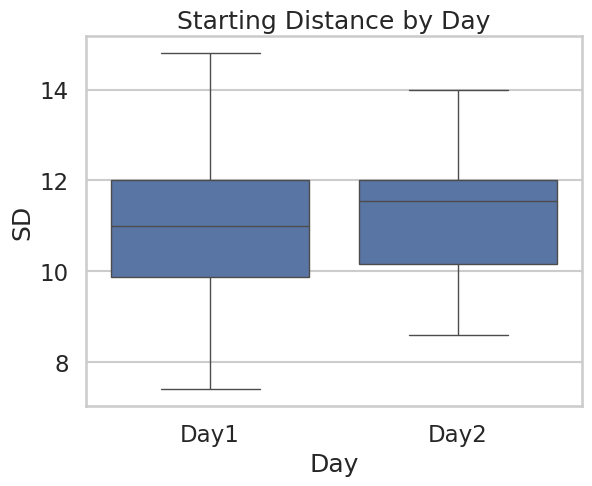

In [34]:
sns.boxplot(data=working_df, x="Day", y="SD")
plt.title("Starting Distance by Day")
plt.show()

Relationship between SD and FID:

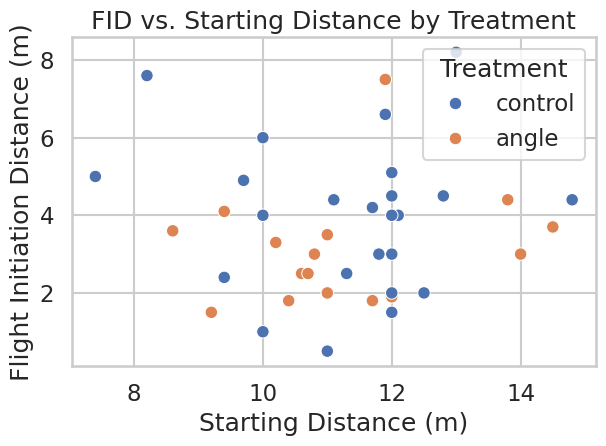

In [17]:
sns.scatterplot(data=df_fid, x="SD", y="FID", hue="Treatment")
plt.ylabel("Flight Initiation Distance (m)")
plt.xlabel("Starting Distance (m)")
plt.title("FID vs. Starting Distance by Treatment")
plt.tight_layout()
plt.show()

Distributional shape of FID:

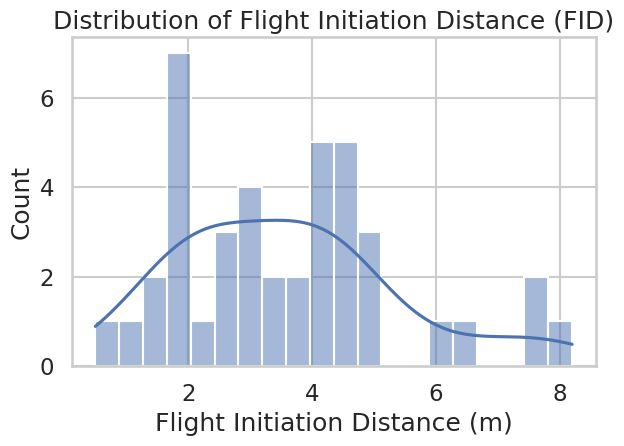

In [19]:
sns.histplot(df_fid["FID"], bins=20, kde=True)
plt.xlabel("Flight Initiation Distance (m)")
plt.title("Distribution of Flight Initiation Distance (FID)")
plt.tight_layout()
plt.show()

FID as a function of Species:

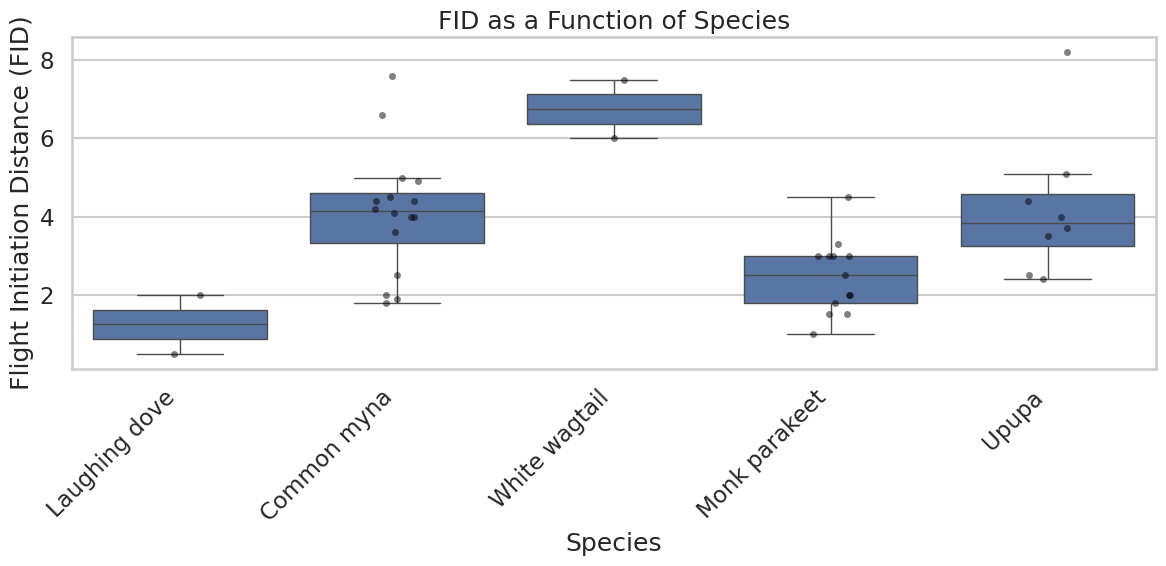

In [35]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df,
    x="Species",
    y="FID",
    showfliers=False
)

sns.stripplot(
    data=df,
    x="Species",
    y="FID",
    color="black",
    alpha=0.5,
    jitter=True
)

plt.xlabel("Species")
plt.ylabel("Flight Initiation Distance (FID)")
plt.title("FID as a Function of Species")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

Violin plots of species (distribution-focused):

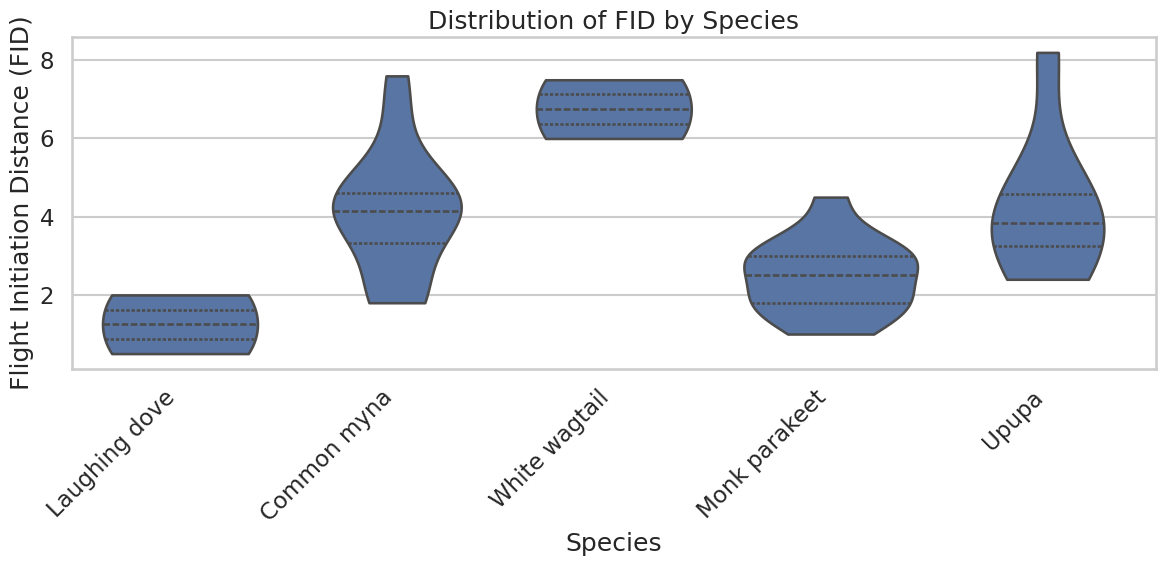

In [37]:
plt.figure(figsize=(12, 6))

sns.violinplot(
    data=df,
    x="Species",
    y="FID",
    inner="quartile",
    cut=0
)

plt.xlabel("Species")
plt.ylabel("Flight Initiation Distance (FID)")
plt.title("Distribution of FID by Species")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

Optional: Mean ± SE (classic behavioural-ecology style) (Summary statistics):

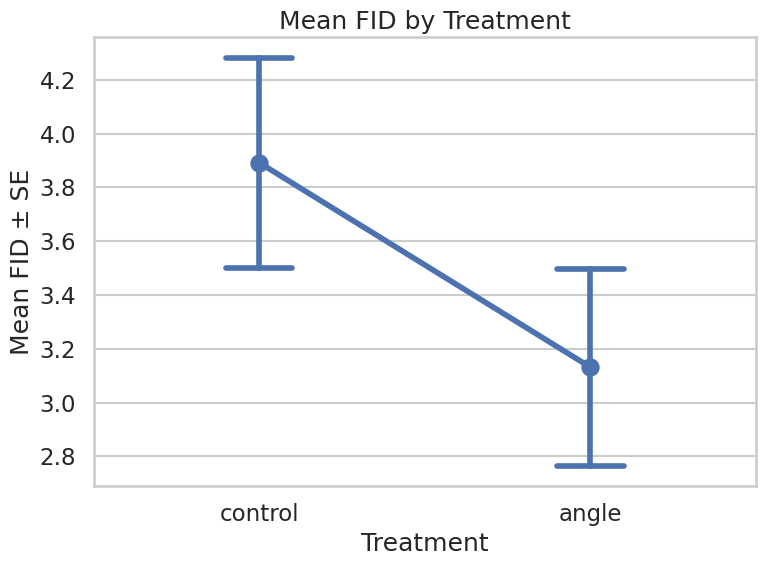

In [38]:
plt.figure(figsize=(8, 6))

sns.pointplot(
    data=df,
    x="Treatment",
    y="FID",
    errorbar="se",
    capsize=0.2
)

plt.xlabel("Treatment")
plt.ylabel("Mean FID ± SE")
plt.title("Mean FID by Treatment")

plt.tight_layout()
plt.show()

In [39]:
pd.crosstab(working_df["Treatment"], working_df["FID"].notna(), margins=True)

FID,False,True,All
Treatment,,,
angle,3,16,19
control,0,25,25
All,3,41,44


In [6]:
df_fled = working_df[working_df["FID"].notna()]

df_fled.groupby("Treatment")["FID"].describe()

,count,mean,std,min,25%,50%,75%,max
Treatment,,,,,,,,
angle,16.0,3.13125,1.464568,1.5,1.975,3.0,3.625,7.5
control,25.0,3.89200,1.949983,0.5,2.400,4.0,4.900,8.2


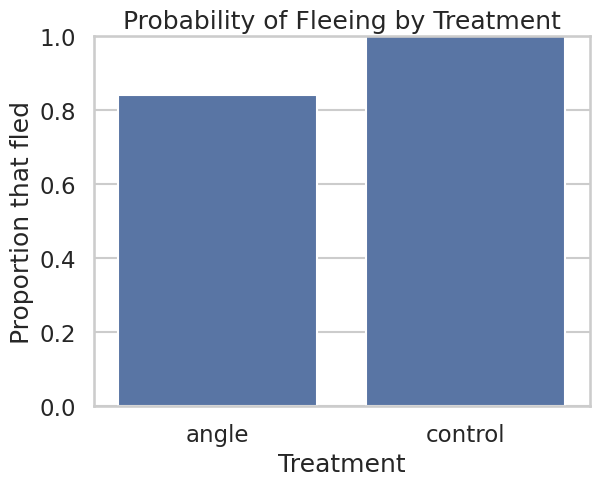

In [8]:
flight_rate = (
    working_df.assign(Fled=working_df["FID"].notna())
      .groupby("Treatment")["Fled"]
      .mean()
      .reset_index()
)

sns.barplot(data=flight_rate, x="Treatment", y="Fled")
plt.ylabel("Proportion that fled")
plt.ylim(0, 1)
plt.title("Probability of Fleeing by Treatment")
plt.show()


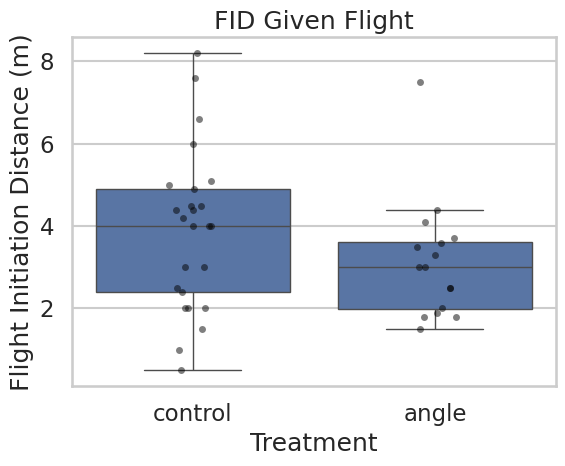

In [9]:
plt.figure(figsize=(6, 5))

sns.boxplot(
    data=df,
    x="Treatment",
    y="FID",
    showfliers=False
)

sns.stripplot(
    data=df,
    x="Treatment",
    y="FID",
    color="black",
    alpha=0.5,
    jitter=True
)

plt.xlabel("Treatment")
plt.ylabel("Flight Initiation Distance (m)")
plt.title("FID Given Flight")

plt.tight_layout()
plt.show()

## High FID analysis:

Some checks on FID > 5, since it is (mostly) above one of the treatments:

In [45]:
high_fid = working_df[working_df["FID"] > 5].copy()

high_fid.shape

(6, 9)

In [46]:
(working_df["FID"] > 5).mean()

np.float64(0.13636363636363635)

In [47]:
high_fid["Observation_No"].tolist()

[104, 107, 111, 122, 233, 239]

In [48]:
high_fid["Species"].value_counts()

Species
Common myna      2
White wagtail    2
Upupa            2
Name: count, dtype: int64

In [49]:
high_fid["Species"].value_counts(normalize=True)

Species
Common myna      0.333333
White wagtail    0.333333
Upupa            0.333333
Name: proportion, dtype: float64

In [50]:
pd.crosstab(high_fid["Treatment"], columns="count")

col_0,count
Treatment,
angle,1
control,5


In [51]:
pd.crosstab(
    working_df["Treatment"],
    working_df["FID"] > 5,
    normalize="index"
)

FID,False,True
Treatment,,
angle,0.947368,0.052632
control,0.800000,0.200000


In [52]:
pd.crosstab(
    high_fid["Immediate_flight"],
    columns="count"
)

col_0,count
Immediate_flight,
False,3
True,3


In [53]:
df.assign(
    HighFID=df["FID"] > 5
).groupby("HighFID")["SD"].describe()

,count,mean,std,min,25%,50%,75%,max
HighFID,,,,,,,,
False,38.0,11.155263,1.589101,7.4,10.000,11.0,12.000,14.8
True,6.0,11.166667,1.748904,8.2,10.475,11.9,11.975,13.0


In [54]:
pd.crosstab(
    df["Grass"],
    df["FID"] > 5,
    normalize="index"
)

FID,False,True
Grass,,
False,1.000000,0.000000
True,0.828571,0.171429


In [55]:
high_fid["Neighbours"].value_counts(dropna=False)

Neighbours
NaN    6
Name: count, dtype: int64

In [56]:
pd.crosstab(
    working_df["Day"],
    working_df["FID"] > 5,
    normalize="index"
)

FID,False,True
Day,,
Day1,0.857143,0.142857
Day2,0.875000,0.125000


## Checking whether "Treatment" is an independent variable

The following is a test to see whether the treatment can be predicted from the results (FID) and the other data (metadata) columns, and whether it is different from predicting it from only the metadata columns:

In [7]:
df_model = df_fled.copy()

In [8]:
y = df_model["Treatment"]

In [19]:
X = df_model[
    ["FID", "SD", "Species", "Grass", "Neighbours", "Day", "Immediate_flight"]
]

In [20]:
numeric_features = ["FID", "SD"]
categorical_features = ["Species", "Grass", "Neighbours", "Day"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ]
)

In [12]:
model = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    max_iter=1000
)

In [13]:
clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", model),
    ]
)

In [21]:
scores = cross_val_score(
    clf,
    X,
    y,
    cv=5,
    scoring="roc_auc"
)

scores, scores.mean()

/home/guy-dude/miniforge3/envs/myjlabenv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/guy-dude/miniforge3/envs/myjlabenv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(array([0.65      , 0.6       , 0.66666667, 0.46666667, 0.6       ]),
 np.float64(0.5966666666666667))

In [25]:
numeric_features_no_fid = ["SD"]
categorical_features_no_fid = ["Species", "Grass", "Neighbours", "Day", "Immediate_flight"]

preprocessor_no_fid = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_no_fid),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features_no_fid),
    ]
)

clf_no_fid = Pipeline(
    steps=[
        ("preprocess", preprocessor_no_fid),
        ("model", LogisticRegression(penalty="l2", solver="liblinear", max_iter=1000)),
    ]
)

X_no_fid = df_model[
    ["SD", "Species", "Grass", "Neighbours", "Day", "Immediate_flight"]
]

scores_no_fid = cross_val_score(clf_no_fid, X_no_fid, y, cv=5, scoring="roc_auc")

scores_no_fid, scores_no_fid.mean()

/home/guy-dude/miniforge3/envs/myjlabenv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/guy-dude/miniforge3/envs/myjlabenv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(array([0.45      , 0.33333333, 0.66666667, 0.46666667, 0.73333333]),
 np.float64(0.53))